# 03 - Model Training

This notebook trains a model to predict transit delays by:
1. Loading prepared training data
2. Training a Random Forest model
3. Evaluating model performance
4. Saving the trained model and feature columns


In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import json
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path('../src').resolve()))
from model import train_model, save_model

# Set up paths
processed_dir = Path('../data/processed')
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("Model Training - Transit Tracker")
print("=" * 60)


Model Training - Transit Tracker


## 1. Load Training Data

Load the training data prepared in notebook 02.


In [2]:
# Load training data
training_data_path = processed_dir / 'training_data.csv'
feature_cols_path = processed_dir / 'feature_columns.json'

if not training_data_path.exists():
    raise FileNotFoundError(
        f"Training data not found at {training_data_path}\n"
        "Please run notebook 02_features.ipynb first!"
    )

print(f"Loading training data from {training_data_path}...")
training_df = pd.read_csv(training_data_path)

# Load feature columns
if feature_cols_path.exists():
    with open(feature_cols_path, 'r') as f:
        feature_cols = json.load(f)
    print(f"Loaded {len(feature_cols)} feature columns")
else:
    # Infer feature columns (all except target)
    feature_cols = [col for col in training_df.columns if col != 'arrival_delay_minutes']
    print(f"Inferred {len(feature_cols)} feature columns")

# Prepare X and y
X = training_df[feature_cols].values
y = training_df['arrival_delay_minutes'].values

print(f"\nTraining data shape: X={X.shape}, y={y.shape}")
print(f"Target variable range: [{y.min():.2f}, {y.max():.2f}] minutes")
print(f"Target variable mean: {y.mean():.2f} minutes")


Loading training data from ../data/processed/training_data.csv...
Loaded 37 feature columns

Training data shape: X=(50235, 37), y=(50235,)
Target variable range: [-85.00, 122.98] minutes
Target variable mean: 15.76 minutes


## 2. Train Model

Train a Random Forest Regressor to predict arrival delays.


In [3]:
# Train model
print("\nTraining Random Forest model...")
print("This may take a few minutes depending on dataset size...")

model, metrics = train_model(X, y, test_size=0.2)

print("\n" + "=" * 60)
print("Model Training Complete!")
print("=" * 60)
print(f"\nModel Performance Metrics:")
print(f"  Mean Absolute Error (MAE): {metrics['mae']:.2f} minutes")
print(f"  Mean Squared Error (MSE): {metrics['mse']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {metrics['rmse']:.2f} minutes")



Training Random Forest model...
This may take a few minutes depending on dataset size...

Model Training Complete!

Model Performance Metrics:
  Mean Absolute Error (MAE): 1.86 minutes
  Mean Squared Error (MSE): 11.71
  Root Mean Squared Error (RMSE): 3.42 minutes


## 3. Feature Importance

Visualize which features are most important for delay prediction.



Top 15 Most Important Features:
                            feature  importance
                         is_delayed    0.191725
       trip_start_scheduled_seconds    0.188661
                  vehicle_frequency    0.130561
                    route_frequency    0.094573
                         route_code    0.077954
                          longitude    0.053924
                           latitude    0.051941
                         is_on_time    0.046877
                        time_of_day    0.031700
                      stop_sequence    0.026685
              current_stop_sequence    0.023123
departure_scheduled_elapsed_seconds    0.017078
          scheduled_elapsed_seconds    0.016064
             departure_time_seconds    0.011335
               arrival_time_seconds    0.011177


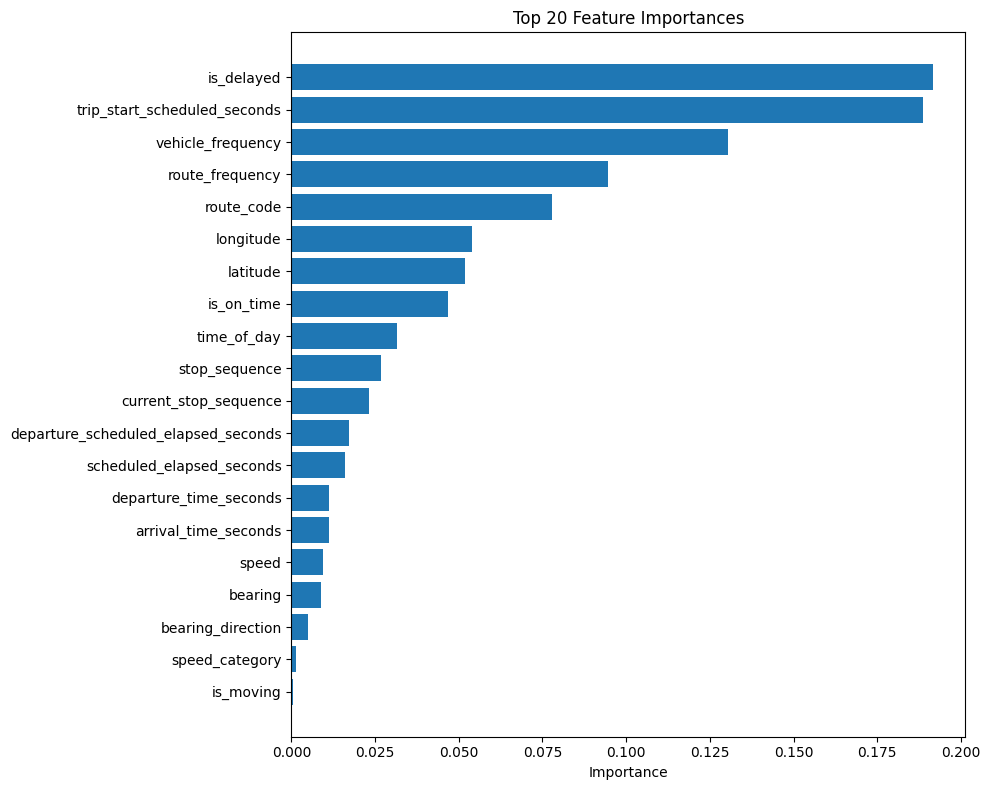

In [4]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = min(20, len(feature_importance))
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 4. Model Predictions Visualization

Visualize model predictions vs actual delays.


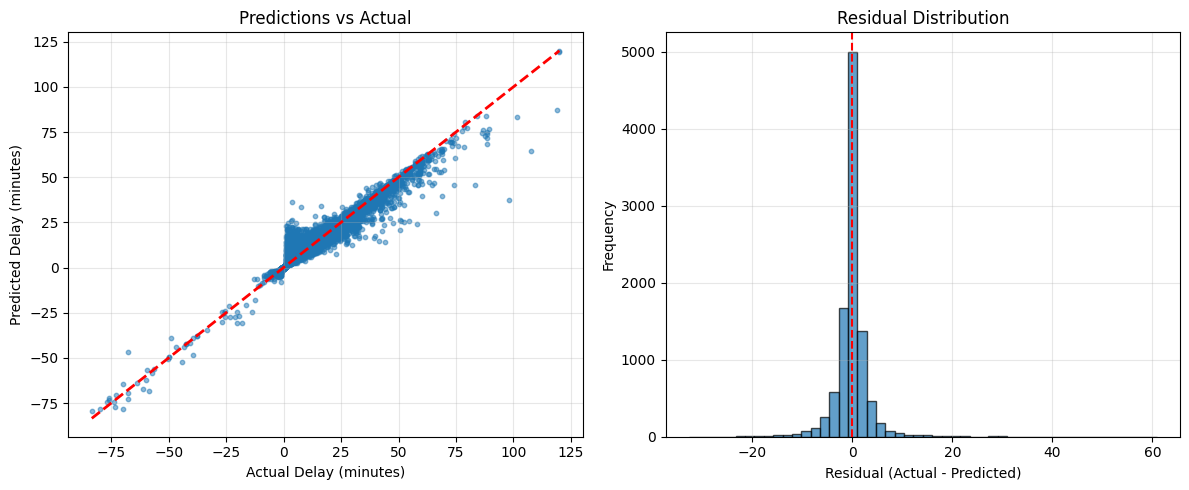


Residual Statistics:
  Mean: -0.12 minutes
  Std: 3.42 minutes


In [5]:
# Get predictions on test set (from train_model function)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = model.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delay (minutes)')
plt.ylabel('Predicted Delay (minutes)')
plt.title('Predictions vs Actual')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.2f} minutes")
print(f"  Std: {residuals.std():.2f} minutes")


## 5. Save Model and Feature Columns

Save the trained model and feature column names for use in predictions.


In [6]:
# Save model
model_path = models_dir / 'travel_time_model.pkl'
save_model(model, model_path)

# Save feature columns (needed for predictions)
feature_cols_save_path = models_dir / 'feature_columns.json'
with open(feature_cols_save_path, 'w') as f:
    json.dump(feature_cols, f)
print(f"Saved feature columns to: {feature_cols_save_path}")

# Save model metrics
metrics_path = models_dir / 'model_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)
print(f"Saved model metrics to: {metrics_path}")

print("\n" + "=" * 60)
print("Model saved successfully!")
print("=" * 60)
print(f"\nYou can now use the model for predictions:")
print(f"  python src/predict.py <route_id>")
print(f"  python src/predict.py <route_id> <stop_id>")


Model saved to ../models/travel_time_model.pkl
Saved feature columns to: ../models/feature_columns.json
Saved model metrics to: ../models/model_metrics.json

Model saved successfully!

You can now use the model for predictions:
  python src/predict.py <route_id>
  python src/predict.py <route_id> <stop_id>
